In [1]:
# Makemore is a character-level language model. 
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

Build Embedding Matrix C

In [7]:
C = torch.randn((27,2)) # 27 is the number unique items that can be embedded - 27 is because we have 26 letters and a dot (.) for the end of the word, 2 is the dimension of the embedding
C[5]

tensor([ 0.7078, -1.2790])

In [8]:
C[X] # This is the embedding matrix, where each row corresponds to a character - 228146x3x2

tensor([[[ 0.8729, -0.1475],
         [ 0.8729, -0.1475],
         [ 0.8729, -0.1475]],

        [[ 0.8729, -0.1475],
         [ 0.8729, -0.1475],
         [ 0.7078, -1.2790]],

        [[ 0.8729, -0.1475],
         [ 0.7078, -1.2790],
         [-0.8113, -1.3429]],

        ...,

        [[ 1.4571, -0.3084],
         [ 1.4571, -0.3084],
         [-0.7205, -1.1472]],

        [[ 1.4571, -0.3084],
         [-0.7205, -1.1472],
         [ 1.4571, -0.3084]],

        [[-0.7205, -1.1472],
         [ 1.4571, -0.3084],
         [-0.3789, -0.9202]]])

In [9]:
X[13,2]

tensor(1)

In [10]:
C[X][13,2]

tensor([-1.6663,  0.3381])

In [11]:
C[1]

tensor([-1.6663,  0.3381])

In [12]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [13]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [14]:
# embeded character for 1st, 2nd, and 3rd character in the context for each sample
(emb[:,0,:],emb[:,1,:],emb[:,2,:])


(tensor([[ 0.8729, -0.1475],
         [ 0.8729, -0.1475],
         [ 0.8729, -0.1475],
         ...,
         [ 1.4571, -0.3084],
         [ 1.4571, -0.3084],
         [-0.7205, -1.1472]]),
 tensor([[ 0.8729, -0.1475],
         [ 0.8729, -0.1475],
         [ 0.7078, -1.2790],
         ...,
         [ 1.4571, -0.3084],
         [-0.7205, -1.1472],
         [ 1.4571, -0.3084]]),
 tensor([[ 0.8729, -0.1475],
         [ 0.7078, -1.2790],
         [-0.8113, -1.3429],
         ...,
         [-0.7205, -1.1472],
         [ 1.4571, -0.3084],
         [-0.3789, -0.9202]]))

In [15]:
# each row is a a context window for each sample, representing by 6 characters (3 characters -normally represented by 27 indexes now embedded in 2 dimensions)
torch.cat((emb[:,0,:],emb[:,1,:],emb[:,2,:]), dim=1)

tensor([[ 0.8729, -0.1475,  0.8729, -0.1475,  0.8729, -0.1475],
        [ 0.8729, -0.1475,  0.8729, -0.1475,  0.7078, -1.2790],
        [ 0.8729, -0.1475,  0.7078, -1.2790, -0.8113, -1.3429],
        ...,
        [ 1.4571, -0.3084,  1.4571, -0.3084, -0.7205, -1.1472],
        [ 1.4571, -0.3084, -0.7205, -1.1472,  1.4571, -0.3084],
        [-0.7205, -1.1472,  1.4571, -0.3084, -0.3789, -0.9202]])

In [16]:
torch.cat(torch.unbind(emb,1),1)

tensor([[ 0.8729, -0.1475,  0.8729, -0.1475,  0.8729, -0.1475],
        [ 0.8729, -0.1475,  0.8729, -0.1475,  0.7078, -1.2790],
        [ 0.8729, -0.1475,  0.7078, -1.2790, -0.8113, -1.3429],
        ...,
        [ 1.4571, -0.3084,  1.4571, -0.3084, -0.7205, -1.1472],
        [ 1.4571, -0.3084, -0.7205, -1.1472,  1.4571, -0.3084],
        [-0.7205, -1.1472,  1.4571, -0.3084, -0.3789, -0.9202]])

In [17]:
emb.view(228146,6)

tensor([[ 0.8729, -0.1475,  0.8729, -0.1475,  0.8729, -0.1475],
        [ 0.8729, -0.1475,  0.8729, -0.1475,  0.7078, -1.2790],
        [ 0.8729, -0.1475,  0.7078, -1.2790, -0.8113, -1.3429],
        ...,
        [ 1.4571, -0.3084,  1.4571, -0.3084, -0.7205, -1.1472],
        [ 1.4571, -0.3084, -0.7205, -1.1472,  1.4571, -0.3084],
        [-0.7205, -1.1472,  1.4571, -0.3084, -0.3789, -0.9202]])

In [18]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 228146x100
h

tensor([[-0.4893,  0.2758, -0.5672,  ...,  0.9367,  0.9297,  0.3255],
        [ 0.4204, -0.4093, -0.9474,  ...,  0.9850,  0.3776,  0.9739],
        [ 0.9458, -0.9747,  0.3381,  ...,  0.8735, -0.9746,  0.9876],
        ...,
        [-0.7738, -0.9890, -0.7677,  ...,  0.9579, -0.6444,  0.9996],
        [ 0.9771,  0.9959,  0.1303,  ...,  0.9976,  0.4212, -0.6880],
        [-0.7395, -0.9494,  0.8766,  ...,  0.4276,  0.5968,  0.7540]])

In [19]:
# pass to the next layer
w2 = torch.randn((100, 27)) # 27 is because the output is a probability distribution over the next character - indexed by 27 numbers ( 5 is [0,0,0,0,1,0..,0])
b2 = torch.randn(27)
logits = h @ w2 + b2 # 228146x27
logits

tensor([[-13.9727,   4.9559,  -8.8116,  ...,   2.5907,   8.9509,  11.3450],
        [-26.0105,   0.7571,  -4.1997,  ...,  -1.7349,   9.6582,  20.1101],
        [-22.8370,   4.7608,  -4.0768,  ...,  -2.7915,   4.3903,  13.8423],
        ...,
        [-18.6054,  -2.1338,   2.8905,  ...,   1.1626,   9.9013,  12.2371],
        [-21.6430,   0.2793, -20.3013,  ...,   3.0682,  -9.3692,   9.2715],
        [ -5.7545,  -2.3937,   2.0008,  ...,   2.6507,   7.3888,   2.1428]])

In [20]:
prob = logits.softmax(dim=1) # 228146x27 - Probability distribution over the next character
prob

tensor([[7.4233e-12, 1.2336e-03, 1.2943e-09,  ..., 1.1587e-04, 6.7017e-02,
         7.3435e-01],
        [9.3331e-21, 3.9360e-09, 2.7692e-11,  ..., 3.2570e-10, 2.8891e-05,
         9.9996e-01],
        [6.6348e-17, 6.4179e-05, 9.3164e-09,  ..., 3.3688e-08, 4.4306e-05,
         5.6421e-01],
        ...,
        [2.4079e-14, 3.4288e-07, 5.2141e-05,  ..., 9.2626e-06, 5.7797e-02,
         5.9751e-01],
        [6.9174e-16, 2.2945e-06, 2.6463e-15,  ..., 3.7315e-05, 1.4805e-10,
         1.8447e-02],
        [6.7375e-07, 1.9411e-05, 1.5724e-03,  ..., 3.0118e-03, 3.4401e-01,
         1.8123e-03]])

In [21]:
prob[0]

tensor([7.4233e-12, 1.2336e-03, 1.2943e-09, 1.1673e-10, 1.4104e-03, 1.6863e-07,
        6.3805e-07, 5.8371e-06, 4.0397e-05, 8.1575e-08, 3.5652e-05, 7.3760e-09,
        8.1950e-10, 7.3840e-05, 5.3811e-06, 1.6249e-06, 1.4433e-11, 3.3186e-04,
        1.2844e-02, 3.7383e-07, 9.0884e-13, 2.9778e-07, 3.8463e-07, 1.8253e-01,
        1.1587e-04, 6.7017e-02, 7.3435e-01])

In [22]:
prob[torch.arange(228146), Y] # the probability of the true next character

tensor([1.6863e-07, 5.7808e-11, 1.1991e-10,  ..., 5.9751e-01, 3.7315e-05,
        6.7375e-07])

In [23]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

Summarising

In [24]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [25]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [26]:
emb = C[X] # 228146x3x2 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 228146x100
logits = h @ W2 + b2 # 228146x27
# counts = logits.exp()
# prob = counts / counts.sum(dim=1, keepdim=True) # 228146x27 - Probability distribution over the next character
# loss = -prob[torch.arange(228146), Y] # 228146x27 - the loss is the negative log probability of the true next character
loss = F.cross_entropy(logits,Y) # cleaner way to compute the loss
loss

tensor(19.5052)

Training

In [27]:
for p in parameters:
  p.requires_grad = True

In [28]:
for _ in range(100):
    #forward pass
    emb = C[X] # 228146x3x2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 228146x100
    logits = h @ W2 + b2 # 228146x27
    loss = F.cross_entropy(logits, Y) # 228146x27
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None # zero the gradients
    loss.backward() # compute gradients
    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad

19.505229949951172
17.084487915039062
15.776532173156738
14.833340644836426
14.002604484558105
13.253260612487793
12.57991886138916
11.983101844787598
11.470492362976074
11.05185604095459
10.709587097167969
10.407632827758789
10.127808570861816
9.864364624023438
9.614503860473633
9.376440048217773
9.148943901062012
8.931110382080078
8.722230911254883
8.521749496459961
8.329227447509766
8.144325256347656
7.966791152954102
7.796450614929199
7.633184909820557
7.476907730102539
7.327520847320557
7.184885025024414
7.04879093170166
6.918952465057373
6.795018196105957
6.676602840423584
6.563317775726318
6.454789161682129
6.350668907165527
6.250643253326416
6.154431343078613
6.061785697937012
5.972482204437256
5.886327743530273
5.803146839141846
5.722784042358398
5.645094394683838
5.569945335388184
5.497212886810303
5.4267802238464355
5.3585357666015625
5.2923760414123535
5.228203296661377
5.165928363800049
5.105468273162842
5.04674768447876
4.98969841003418
4.934261322021484
4.880379676818848

In [29]:
# This is quite slow, forward and backward all samples at the same time, we can do it in minibatches
batch_size = 32
for _ in range(100):
    ix = torch.randint(0, X.shape[0], (batch_size,)) # random sample of indices
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # (32,)
    print(loss.item())
    for p in parameters:
        p.grad = None # zero the gradients
    loss.backward() # compute gradients
    for p in parameters:
        p.data += -0.1 * p.grad

3.53702712059021
3.2929763793945312
3.9791529178619385
3.9958889484405518
2.893460988998413
3.8604660034179688
3.796879768371582
4.582971572875977
3.460191488265991
3.3977694511413574
2.947091817855835
3.3546433448791504
3.715304374694824
3.426414966583252
2.845067024230957
4.418564319610596
3.582770347595215
3.13973331451416
4.194923400878906
3.7180545330047607
4.27455472946167
3.6149044036865234
3.354079008102417
3.8736817836761475
2.80570125579834
2.8492369651794434
2.8003270626068115
3.7566475868225098
3.8840489387512207
3.3215808868408203
3.0654828548431396
3.0075385570526123
3.768889904022217
3.638179063796997
3.2446892261505127
3.0981786251068115
3.5584332942962646
3.1655092239379883
3.2230072021484375
3.3310678005218506
2.910835027694702
3.38413405418396
2.9819490909576416
3.6095664501190186
3.3153765201568604
3.463228225708008
3.1427271366119385
3.0825440883636475
3.4808623790740967
2.946232318878174
4.136052131652832
3.0535924434661865
3.6121938228607178
2.9217305183410645
2.

Find a good intial learning rate

In [30]:
lre = torch.linspace(-3, 0, 1000) # learning rate from 10^-3 to 1
lrs = 10**lre # learning rates
lri = []
lossi = []

In [31]:
for i in range(1000):
    ix = torch.randint(0, X.shape[0], (batch_size,)) # random sample of indices
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # (32,)
    print(loss.item())
    for p in parameters:
        p.grad = None # zero the gradients
    loss.backward() # compute gradients
    for j,p in enumerate(parameters):
        p.data += -lrs[i] * p.grad

    # track stats
    lri.append(lrs[i])
    lossi.append(loss.item())

3.399075746536255
3.428058385848999
2.5402352809906006
3.423403024673462
3.2811269760131836
3.22678804397583
2.7704150676727295
3.2005536556243896
3.1455845832824707
3.405702590942383
2.4789235591888428
3.2434470653533936
3.2144598960876465
2.5557212829589844
3.1846933364868164
3.1081838607788086
2.965428113937378
3.2278709411621094
3.25217342376709
2.94319486618042
4.221297264099121
2.875420331954956
2.6964588165283203
3.184100866317749
3.4381673336029053
3.3257968425750732
2.800955295562744
3.1897802352905273
3.1036508083343506
3.1988296508789062
2.937404155731201
3.364089250564575
2.7993762493133545
3.3930306434631348
2.596634864807129
2.7098164558410645
3.1398186683654785
2.8487281799316406
2.9794156551361084
3.426412343978882
2.736522674560547
3.107971668243408
2.9096462726593018
2.837960720062256
2.7236104011535645
3.299370050430298
2.946073293685913
3.108440637588501
2.4152638912200928
3.1958789825439453
2.4582462310791016
3.2689294815063477
2.8632495403289795
3.4191808700561523

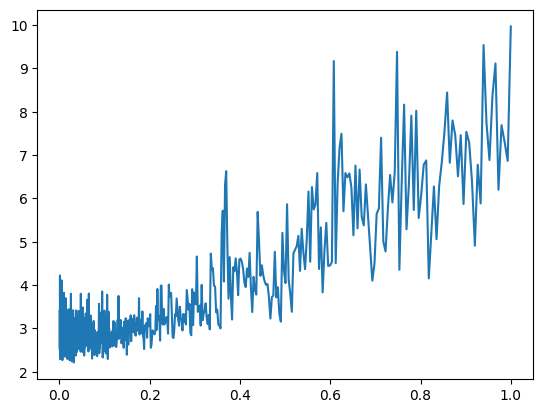

In [32]:
plt.plot(lri, lossi)

In [33]:
# start with 0.1 then reduce it to 0.01
for i in range(1000):
    ix = torch.randint(0, X.shape[0], (batch_size,)) # random sample of indices
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # (32,)
    print(loss.item())
    for p in parameters:
        p.grad = None # zero the gradients
    loss.backward() # compute gradients
    lri = 0.01
    for j,p in enumerate(parameters):
        p.data += -lri * p.grad


7.390805721282959
6.747064113616943
7.079575538635254
5.827226161956787
5.337015151977539
7.603969097137451
7.328300476074219
6.530324459075928
4.732528209686279
6.2200236320495605
6.527544021606445
7.25449800491333
5.821243762969971
6.226077079772949
6.0989909172058105
6.574773788452148
7.1806440353393555
6.575961589813232
5.992979049682617
7.303930759429932
5.752108097076416
5.725229740142822
6.279650688171387
6.234786033630371
5.244513988494873
5.9116621017456055
6.495723724365234
6.3617119789123535
6.839570999145508
5.540745258331299
4.676394462585449
7.380643844604492
4.410592079162598
5.232960224151611
4.705787181854248
6.026326656341553
5.707932472229004
5.637294769287109
6.056506633758545
4.677033424377441
5.50400447845459
5.491945743560791
6.0294389724731445
5.042019844055176
5.393111228942871
5.14100456237793
5.594744682312012
6.380053997039795
6.325802326202393
5.882419109344482
4.9505181312561035
5.346967697143555
4.8852386474609375
5.0886335372924805
5.555776119232178
4.86

Increasing number of parameters

In [47]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [48]:
for p in parameters:
  p.requires_grad = True
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [58]:
#we can split the data into train/validation/test sets
n = X.shape[0] # number of samples
n_tr = int(0.8 * n) # 80% for training
n_val = int(0.1 * n) # 10% for validation
n_te = n - n_tr - n_val # 10% for testing
Xtr, Ytr = X[:n_tr], Y[:n_tr] # training set
Xval, Yval = X[n_tr:n_tr+n_val], Y[n_tr:n_tr+n_val] # validation set    
Xte, Yte = X[n_tr+n_val:], Y[n_tr+n_val:] # test set
# Now we can train on the training set and validate on the validation set
for i in range(20000):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # random sample of indices
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) 
    print(loss.item())
    for p in parameters:
        p.grad = None # zero the gradients
    loss.backward() # compute gradients
    lr = 0.1 if i < 10000 else 0.01 # learning rate
     # update parameters
     # for j,p in enumerate(parameters):
     #     p.data += -lri * p.grad
    for j,p in enumerate(parameters):
        p.data += -lr * p.grad
# Now we can validate on the validation set
# for i in range(1000):
#     ix = torch.randint(0, Xval.shape[0], (batch_size,)) # random sample of indices
#     emb = C[Xval[ix]] # (32, 3, 2)
#     h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
#     logits = h @ W2 + b2 # (32, 27)
#     loss = F.cross_entropy(logits, Yval[ix]) # (32,)
#     print(loss.item())


2.650555372238159
3.682577133178711
3.7957797050476074
4.036678314208984
3.2987871170043945
2.9740495681762695
3.810896873474121
3.3111836910247803
2.830420970916748
2.6677136421203613
4.086617946624756
2.698523759841919
3.023527145385742
3.6383368968963623
2.9002015590667725
2.8730552196502686
3.1701157093048096
3.2130701541900635
2.5465190410614014
3.8038573265075684
3.3007447719573975
2.525665044784546
3.4342122077941895
2.71844220161438
3.2292470932006836
3.766007900238037
2.8963348865509033
4.786770343780518
3.1665098667144775
4.106769561767578
3.7222142219543457
2.2877745628356934
3.717313766479492
3.964954137802124
3.740647077560425
2.8534512519836426
3.4182918071746826
2.8386569023132324
3.529033660888672
4.327552318572998
3.533026695251465
4.041268825531006
4.486470699310303
3.615581750869751
3.3573384284973145
3.377169609069824
2.8368330001831055
3.3517134189605713
2.6613564491271973
4.016873359680176
3.0287234783172607
3.981914758682251
3.690335273742676
2.3136274814605713
3

In [59]:
#Calculate the loss on the test set
emb = C[Xte] 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2 # (n_te, 27)
prob = logits.softmax(dim=1) # (n_te, 27) - Probability distribution over the next character
loss = F.cross_entropy(logits, Yte) # (n_te,) - the loss
loss

tensor(2.5785, grad_fn=<NllLossBackward0>)

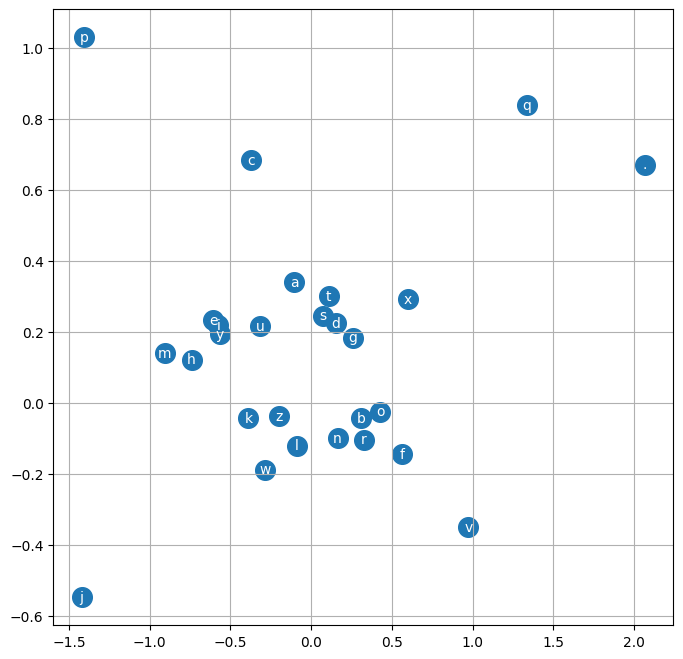

In [57]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [60]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carlah.
ambrilli.
kimri.
reah.
khalaysa.
jazhnen.
den.
rha.
kaqui.
nellaiah.
maiiy.
kaleig.
dham.
join.
quint.
sroilah.
jamii.
wapelosiearynixah.
eupinsa.
mel.
